In [ ]:
#load datasets
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import date
import matplotlib.pyplot as plt

df_cities = pd.read_csv('../data/cities.csv')
df_fires = pd.read_csv('../data/wildfires_fires_table.csv') #fire size in acres
df_us_weather = pd.read_parquet('../data/us_daily_weather_1992_2015.parquet')





# Keep only US stations
df_cities_us = df_cities[df_cities["country"] == "United States of America"].copy()

lat_col = "latitude"    # adjust if different
lon_col = "longitude"   # adjust if different

coords = df_cities_us[[lat_col, lon_col]].to_numpy()


C:\Users\SPAC-18\AppData\Local\Temp\ipykernel_31308\3878022752.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fires = pd.read_csv('../data/wildfires_fires_table.csv') #fire size in acres


Val ROC-AUC: 0.8548332771069986
Val PR-AUC: 0.9523382327234242
Test ROC-AUC: 0.8489475904946915
Test PR-AUC: 0.9385007097185429


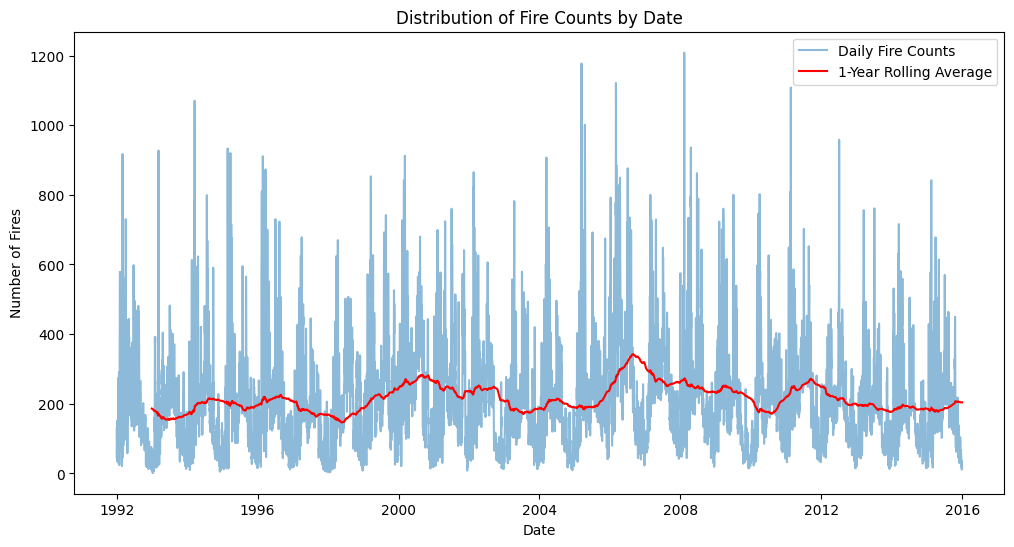

In [39]:
#exploratory analysis
# show distribution of fire counts by date
#as well as rolling one year average

df_fires['DISCOVERY_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'])
fire_counts = df_fires.groupby('DISCOVERY_DATE').size()
fire_counts_rolling = fire_counts.rolling(window=365).mean()
plt.figure(figsize=(12, 6))
plt.plot(fire_counts.index, fire_counts.values, label='Daily Fire Counts', alpha=0.5)
plt.plot(fire_counts_rolling.index, fire_counts_rolling.values, label='1-Year Rolling Average', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Fires')
plt.title('Distribution of Fire Counts by Date')
plt.legend()
plt.show()

Shows clear cyclical trends as well as as a slight increase over time.
Lets look at fire size distribution

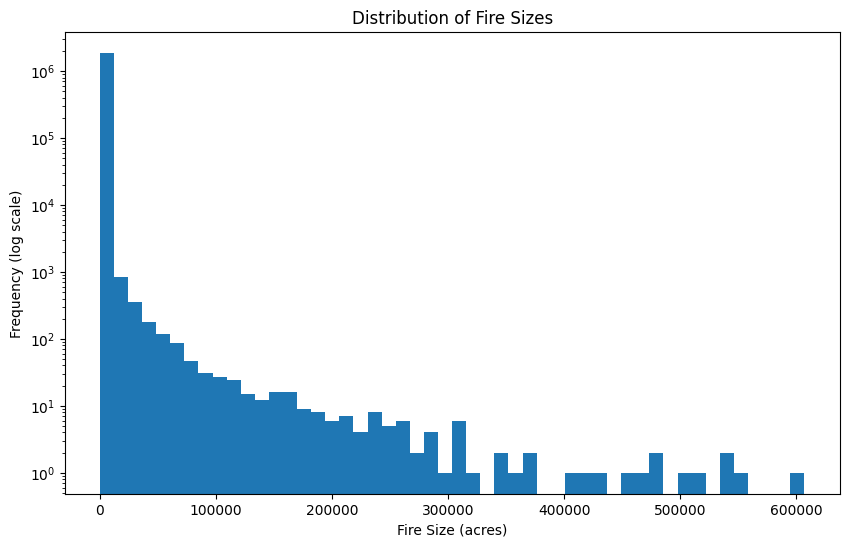

In [40]:
#plot fire size distribution
plt.figure(figsize=(10, 6))
plt.hist(df_fires['FIRE_SIZE'], bins=50, log=True)
plt.xlabel('Fire Size (acres)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Fire Sizes')
plt.show()  

In [ ]:

n_regions = 20  # try 10, 20, etc.
kmeans = KMeans(
    n_clusters=n_regions,
    random_state=42,
    n_init="auto",
)
df_cities_us["region"] = kmeans.fit_predict(coords)

# Keep only needed columns to merge later
station_regions = df_cities_us[["station_id", "region"]].copy()


df_us_weather = df_us_weather.merge(
    station_regions,
    on="station_id",
    how="inner",  # drop stations not in df_cities_us
)

#set weather regions

# Ensure consistent datetime
df_us_weather["date"] = pd.to_datetime(df_us_weather["date"])

# Basic region–day aggregates (keep it small at first)
agg_dict = {
    "avg_temp_c": "mean",
    "min_temp_c": "mean",
    "max_temp_c": "mean",
    "precipitation_mm": "sum",      # sum over stations in region
    "avg_wind_speed_kmh": "mean",
    "avg_sea_level_pres_hpa": "mean",
}

weather_region_day = (
    df_us_weather.groupby(["region", "date"])
    .agg(agg_dict)
    .reset_index()
)

# Optional: change dtypes to save memory
float_cols = [c for c in weather_region_day.columns if weather_region_day[c].dtype == "float64"]
weather_region_day[float_cols] = weather_region_day[float_cols].astype("float32")


# Add rolling features
weather_region_day = weather_region_day.sort_values(["region", "date"])
grouped = weather_region_day.groupby("region", group_keys=False)

# 7-day rolling precipitation sum
weather_region_day["prcp_7d_sum"] = (
    grouped["precipitation_mm"]
    .rolling(7, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# 14-day rolling mean max_temp
weather_region_day["tmax_14d_mean"] = (
    grouped["max_temp_c"]
    .rolling(14, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Day-of-year (for seasonality)
weather_region_day["doy"] = weather_region_day["date"].dt.dayofyear


weather_region_day["sin_doy"] = np.sin(2 * np.pi * weather_region_day["doy"] / 365.0)
weather_region_day["cos_doy"] = np.cos(2 * np.pi * weather_region_day["doy"] / 365.0)


#assign regions to fires

# Clean up fire dates & range
df_fires = df_fires.dropna(subset=["DISCOVERY_DATE", "LATITUDE", "LONGITUDE"]).copy()

df_fires["DISCOVERY_DATE"] = pd.to_datetime(df_fires["DISCOVERY_DATE"])

df_fires = df_fires[
    (df_fires["DISCOVERY_DATE"] >= "1992-01-01")
    & (df_fires["DISCOVERY_DATE"] <= "2015-12-31")
]

# Compute region for each fire using previously fitted kmeans
fire_coords = df_fires[["LATITUDE", "LONGITUDE"]].to_numpy()
df_fires["region"] = kmeans.predict(fire_coords)

# Region–day fire count and binary label
fires_region_day = (
    df_fires.groupby(["region", "DISCOVERY_DATE"])
    .size()
    .reset_index(name="fire_count")
)
fires_region_day["fire_occurred"] = (fires_region_day["fire_count"] > 0).astype(int)

#merge weather and fire data



data = weather_region_day.merge(
    fires_region_day[["region", "DISCOVERY_DATE", "fire_occurred"]],
    left_on=["region", "date"],
    right_on=["region", "DISCOVERY_DATE"],
    how="left",
)

data["fire_occurred"] = data["fire_occurred"].fillna(0).astype(int)

# Drop redundant column
data = data.drop(columns=["DISCOVERY_DATE"])


data = data.sort_values(["region", "date"]).copy()

data["year"] = data["date"].dt.year.astype("int16")
data["time_idx"] = (data["date"] - data["date"].min()).dt.days.astype("int32")

#train split

train = data[data["date"] < "2011-01-01"].copy()
val = data[(data["date"] >= "2011-01-01") & (data["date"] < "2014-01-01")].copy()
test = data[data["date"] >= "2014-01-01"].copy()

feature_cols = [
    "avg_temp_c",
    "min_temp_c",
    "max_temp_c",
    "precipitation_mm",
    "avg_wind_speed_kmh",
    "avg_sea_level_pres_hpa",
    "prcp_7d_sum",
    "tmax_14d_mean",
    "sin_doy",
    "cos_doy",
    "year",
    "time_idx",
]

X_train, y_train = train[feature_cols], train["fire_occurred"]
X_val, y_val = val[feature_cols], val["fire_occurred"]
X_test, y_test = test[feature_cols], test["fire_occurred"]


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

clf = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=200,
    class_weight="balanced",
    random_state=42,
)

clf.fit(X_train, y_train)

probs_val = clf.predict_proba(X_val)[:, 1]
probs_test = clf.predict_proba(X_test)[:, 1]

print("Val ROC-AUC:", roc_auc_score(y_val, probs_val))
print("Val PR-AUC:", average_precision_score(y_val, probs_val))
print("Test ROC-AUC:", roc_auc_score(y_test, probs_test))
print("Test PR-AUC:", average_precision_score(y_test, probs_test))

In [3]:
from sklearn.cluster import KMeans

# Keep only US stations
df_cities_us = df_cities[df_cities["country"] == "United States of America"].copy()

lat_col = "latitude"    # adjust if different
lon_col = "longitude"   # adjust if different

coords = df_cities_us[[lat_col, lon_col]].to_numpy()

n_regions = 20  # try 10, 20, etc.
kmeans = KMeans(
    n_clusters=n_regions,
    random_state=42,
    n_init="auto",
)
df_cities_us["region"] = kmeans.fit_predict(coords)

# Keep only needed columns to merge later
station_regions = df_cities_us[["station_id", "region"]].copy()

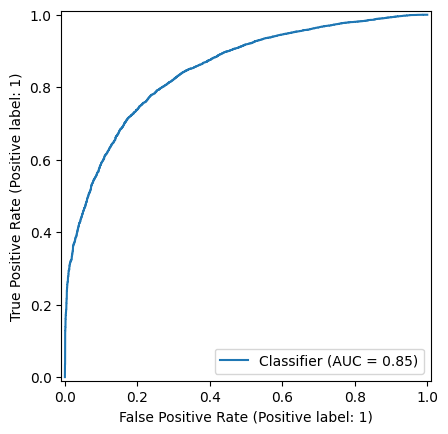

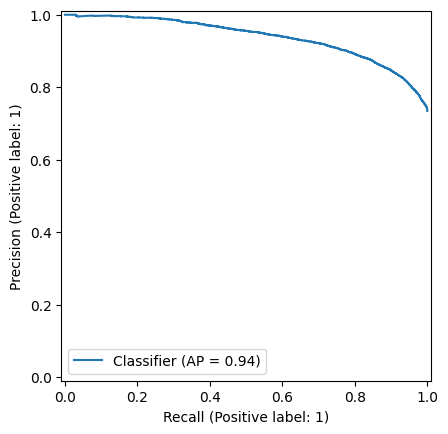

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_predictions(y_test, probs_test)
PrecisionRecallDisplay.from_predictions(y_test, probs_test)
plt.show()



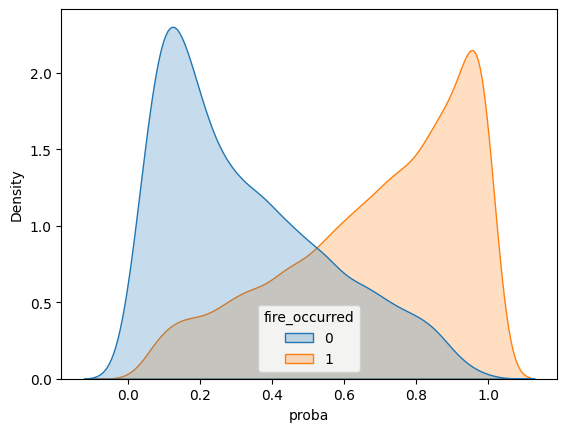

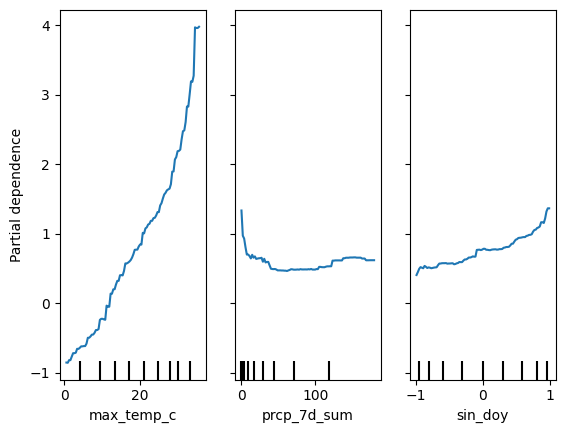

In [5]:


import seaborn as sns
plot_df = pd.DataFrame({'proba': probs_test, 'fire_occurred': y_test})
sns.kdeplot(data=plot_df, x='proba', hue='fire_occurred', common_norm=False, fill=True)


from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs_test, n_bins=10)


from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
importances = pd.Series(result.importances_mean, index=feature_cols).sort_values(ascending=False)


from sklearn.inspection import PartialDependenceDisplay
features_to_plot = ["max_temp_c", "prcp_7d_sum", "sin_doy"]  # Can adjust as needed
PartialDependenceDisplay.from_estimator(clf, X_val, features_to_plot, kind="average")
plt.show()


In [6]:
from datetime import date

# Clean up fire dates & range
df_fires = df_fires.dropna(subset=["DISCOVERY_DATE", "LATITUDE", "LONGITUDE"]).copy()

df_fires["DISCOVERY_DATE"] = pd.to_datetime(df_fires["DISCOVERY_DATE"])

df_fires = df_fires[
    (df_fires["DISCOVERY_DATE"] >= "1992-01-01")
    & (df_fires["DISCOVERY_DATE"] <= "2015-12-31")
]

# Compute region for each fire using previously fitted kmeans
fire_coords = df_fires[["LATITUDE", "LONGITUDE"]].to_numpy()
df_fires["region"] = kmeans.predict(fire_coords)

# Region–day fire count and binary label
fires_region_day = (
    df_fires.groupby(["region", "DISCOVERY_DATE"])
    .size()
    .reset_index(name="fire_count")
)
fires_region_day["fire_occurred"] = (fires_region_day["fire_count"] > 0).astype(int)

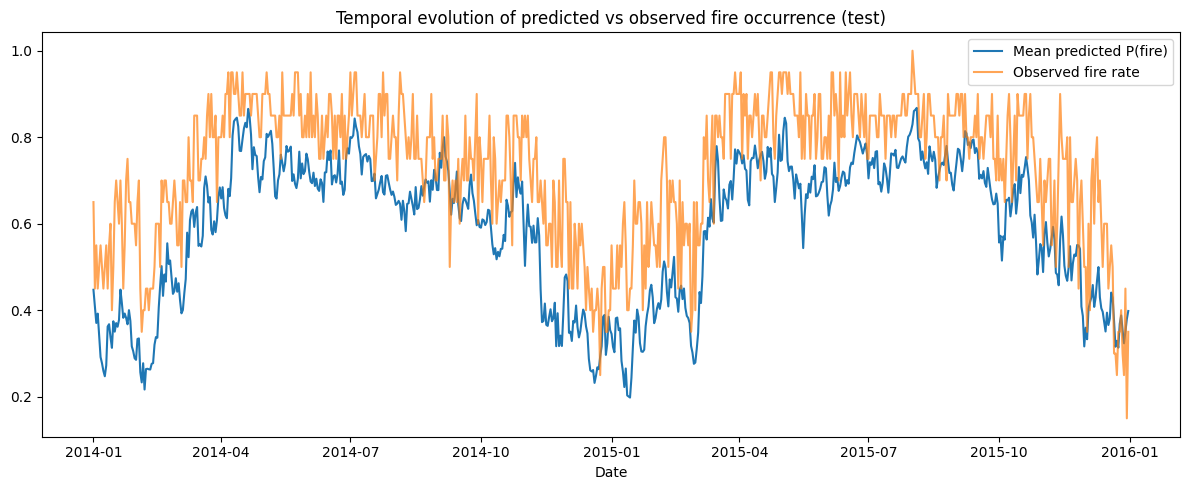

In [7]:
test_with_preds = test.copy()
test_with_preds["proba"] = probs_test

daily = (
    test_with_preds.groupby("date")
    .agg(
        mean_pred=("proba", "mean"),
        fire_rate=("fire_occurred", "mean"),
    )
    .reset_index()
)

plt.figure(figsize=(12, 5))
plt.plot(daily["date"], daily["mean_pred"], label="Mean predicted P(fire)")
plt.plot(daily["date"], daily["fire_rate"], label="Observed fire rate", alpha=0.7)
plt.legend()
plt.xlabel("Date")
plt.title("Temporal evolution of predicted vs observed fire occurrence (test)")
plt.tight_layout()
plt.show()

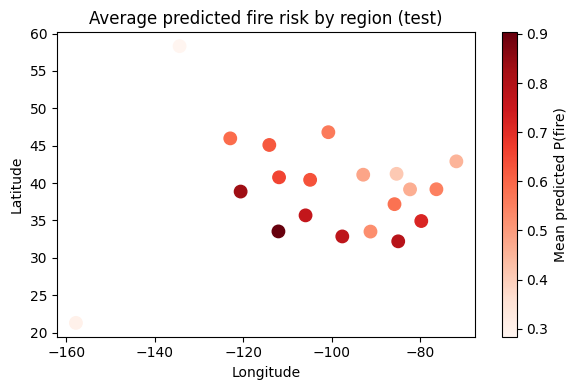

In [8]:
# Get cluster centers (lat, lon) from the fitted kmeans
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=["lat", "lon"],
).reset_index().rename(columns={"index": "region"})

# Mean predicted probability per region in test set
region_mean = (
    test_with_preds.groupby("region")["proba"]
    .mean()
    .reset_index(name="mean_proba")
)

region_plot = centers.merge(region_mean, on="region", how="left")

plt.figure(figsize=(6, 4))
sc = plt.scatter(
    region_plot["lon"],
    region_plot["lat"],
    c=region_plot["mean_proba"],
    cmap="Reds",
    s=80,
)
plt.colorbar(sc, label="Mean predicted P(fire)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Average predicted fire risk by region (test)")
plt.tight_layout()
plt.show()

In [9]:
#export region clusters to csv with pfire risk
region_plot.to_csv('../data/region_clusters.csv', index=False)

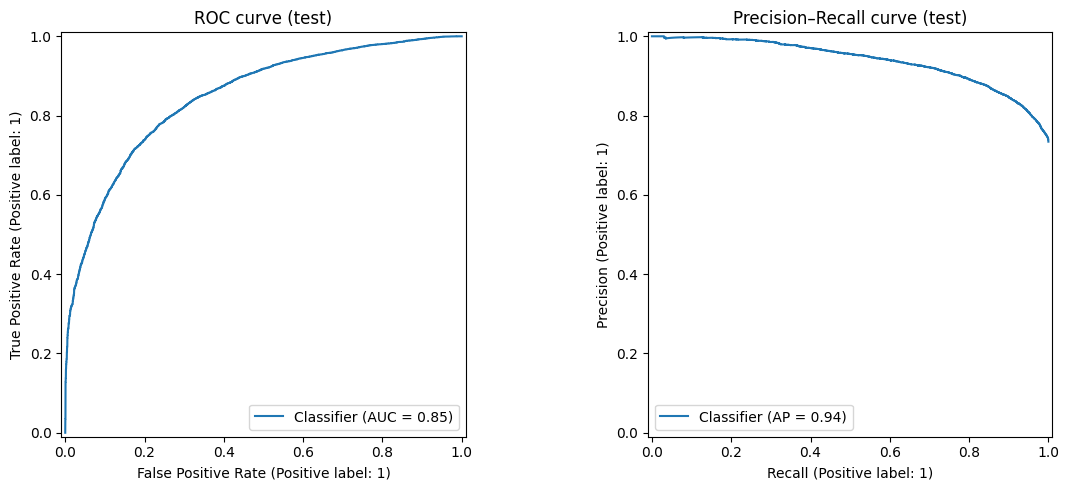

In [10]:

centers = pd.DataFrame(kmeans.cluster_centers_, columns=["lat", "lon"])
region_mean = test_with_preds.groupby("region")["proba"].mean().reset_index()
centers = centers.reset_index().rename(columns={"index": "region"})
region_plot = centers.merge(region_mean, on="region", how="left")


from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_test, probs_test, ax=axes[0])
axes[0].set_title("ROC curve (test)")

PrecisionRecallDisplay.from_predictions(y_test, probs_test, ax=axes[1])
axes[1].set_title("Precision–Recall curve (test)")

plt.tight_layout()
plt.show()


In [11]:
#most dangeorous conditions

test_with_preds = test.copy()
test_with_preds["proba"] = probs_test

# Define high / low risk by quantiles on test set
high_q = 0.99   # top 1% highest-risk region-days
low_q = 0.10    # bottom 10% lowest-risk region-days

high_thr = test_with_preds["proba"].quantile(high_q)
low_thr = test_with_preds["proba"].quantile(low_q)

high_risk = test_with_preds[test_with_preds["proba"] >= high_thr]
low_risk = test_with_preds[test_with_preds["proba"] <= low_thr]

print(len(high_risk), "high-risk samples")
print(len(low_risk), "low-risk samples")

146 high-risk samples
1460 low-risk samples


In [12]:
feature_cols = [
    "avg_temp_c",
    "min_temp_c",
    "max_temp_c",
    "precipitation_mm",
    "avg_wind_speed_kmh",
    "avg_sea_level_pres_hpa",
    "prcp_7d_sum",
    "tmax_14d_mean",
    "sin_doy",
    "cos_doy",
]

summary_high = high_risk[feature_cols].describe().loc[["mean", "50%"]]
summary_low = low_risk[feature_cols].describe().loc[["mean", "50%"]]

summary = pd.concat(
    {"high_risk": summary_high, "low_risk": summary_low},
    axis=0,
)
summary.transpose()

high_risk                  low_risk             
                               mean          50%         mean          50%
avg_temp_c                35.005478    35.400002     0.023133    -0.650000
min_temp_c                28.452396    28.900000    -3.599703    -3.200000
max_temp_c                41.430138    41.700001     3.688985     2.800000
precipitation_mm           0.385616     0.000000     6.583151     0.800000
avg_wind_speed_kmh        11.643493    11.500000    12.939001    12.002857
avg_sea_level_pres_hpa  1007.244995  1007.299988  1018.314209  1018.054993
prcp_7d_sum                2.217123     0.000000    40.649383    20.200000
tmax_14d_mean             40.581898    40.939286     4.892922     3.354762
sin_doy                   -0.221021    -0.205097     0.082215     0.137279
cos_doy                   -0.860792    -0.938377     0.765339     0.882015

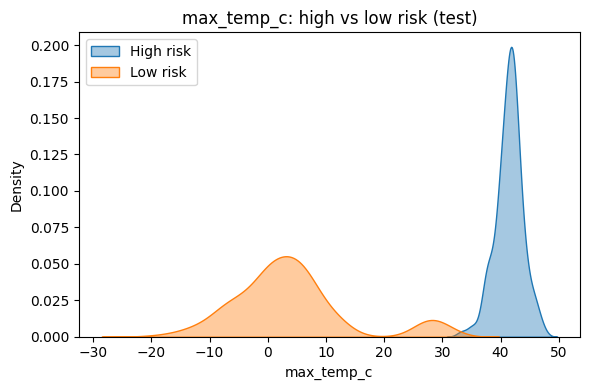

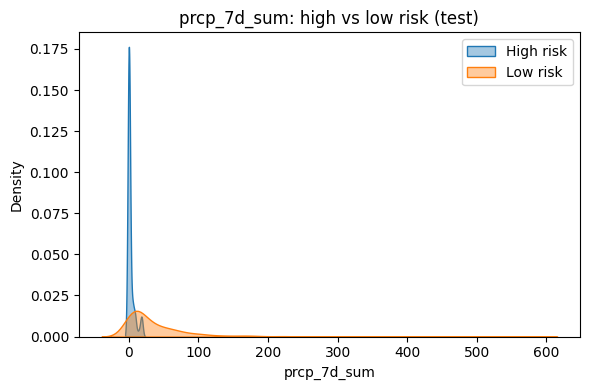

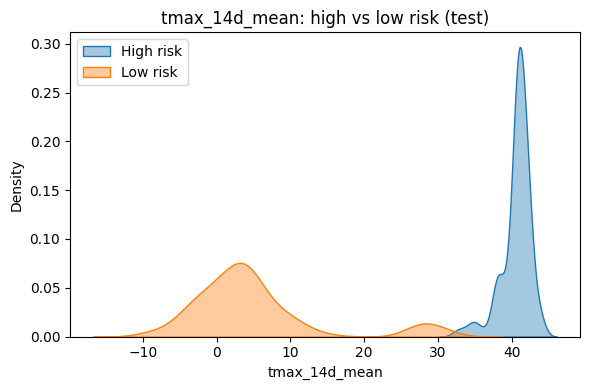

In [13]:
for col in ["max_temp_c", "prcp_7d_sum", "tmax_14d_mean"]:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(high_risk[col], label="High risk", fill=True, alpha=0.4)
    sns.kdeplot(low_risk[col], label="Low risk", fill=True, alpha=0.4)
    plt.title(f"{col}: high vs low risk (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

**This draws a clear picture of the feature distributions:** 

Low percipitation and high max temperature for a period are risk factors

Lets investigate how the dates relate

In [14]:
month_name_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}
test_with_preds["month"] = test_with_preds["date"].dt.month
monthly = (
    test_with_preds.groupby("month")
    .agg(
        mean_pred=("proba", "mean"),
        fire_rate=("fire_occurred", "mean"),
    )
    .reset_index()
)

#change month number to month name
monthly["month"] = monthly["month"].map(month_name_dict)
monthly

,month,mean_pred,fire_rate
0,January,0.340788,0.554032
1,February,0.396480,0.581250
2,March,0.590856,0.755645
3,April,0.743483,0.868333
4,May,0.720580,0.860484
5,June,0.718936,0.840000
6,July,0.735817,0.846774
7,August,0.707570,0.814516
8,September,0.702987,0.775000
9,October,0.618827,0.761290


This shows a clear difference in months, which of course is to be expected

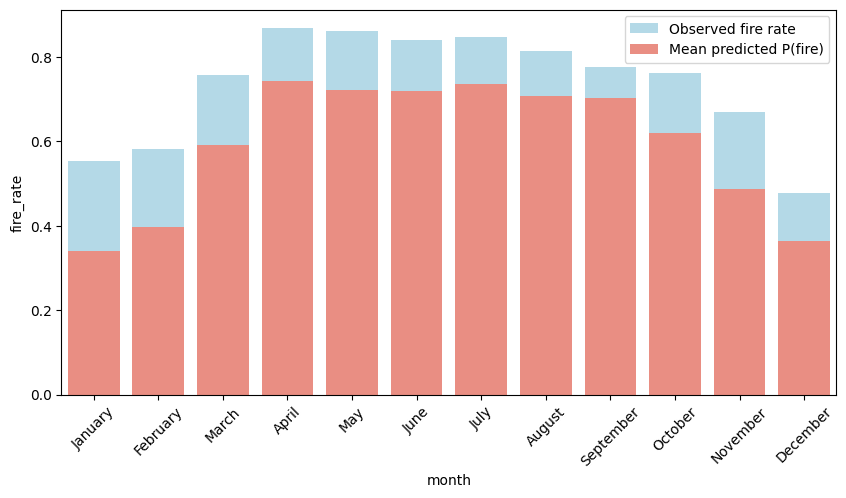

In [15]:
#show histogram of the monthly df for high and low risk samples with rotated x labels
plt.figure(figsize=(10, 5))
sns.barplot(x="month", y="fire_rate", data=monthly, color="skyblue", label="Observed fire rate", alpha=0.7)
sns.barplot(x="month", y="mean_pred", data=monthly, color="salmon", label="Mean predicted P(fire)")

plt.xticks(rotation=45) 
plt.legend()
plt.show()

The model seems to be a bit conservative, since the p(fire) is always cosiderably lower

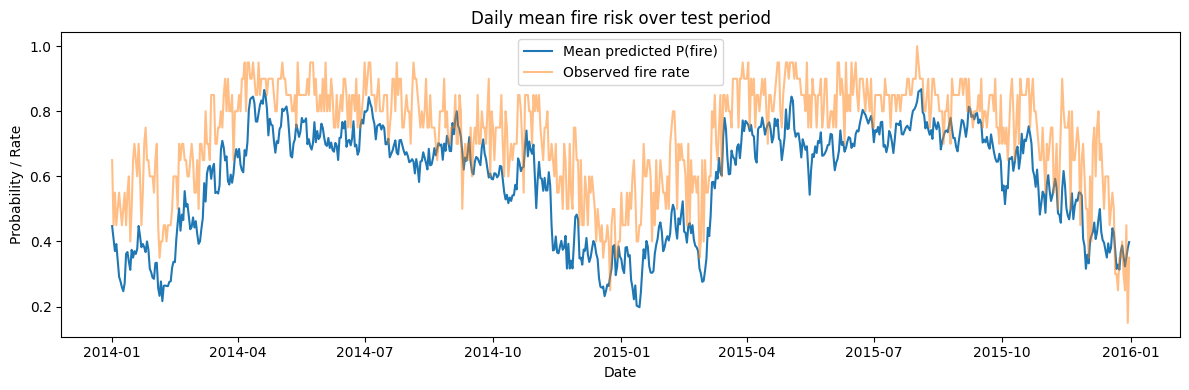

In [16]:
daily = (
    test_with_preds.groupby("date")
    .agg(
        mean_pred=("proba", "mean"),
        fire_rate=("fire_occurred", "mean"),
    )
    .reset_index()
)

plt.figure(figsize=(12, 4))
plt.plot(daily["date"], daily["mean_pred"], label="Mean predicted P(fire)")
plt.plot(daily["date"], daily["fire_rate"], alpha=0.5, label="Observed fire rate")
plt.xlabel("Date")
plt.ylabel("Probability / Rate")
plt.title("Daily mean fire risk over test period")
plt.legend()
plt.tight_layout()
plt.show()

This follows the general trend of underprediction. Why?

I would guess that it's because the training set is earlier than the test set. There is something in the time progression that isn't captured by the variables we use as predictors.

 Most wildfires are manmade, so some of the underprediction could be related to this. Maybe population increase? Could also be more complex climate behavior.

Lets also look into region specific trends

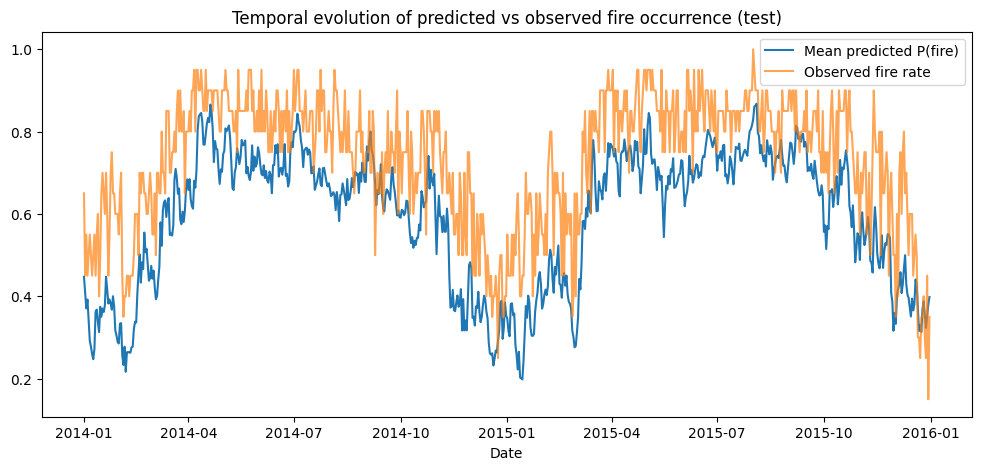

In [ ]:
#plot test set preditions vs actuals over time
plt.figure(figsize=(12, 5))
plt.plot(daily["date"], daily["mean_pred"], label="Mean predicted P(fire)")
plt.plot(daily["date"], daily["fire_rate"], label="Observed fire rate", alpha=0.7)
plt.legend()
plt.xlabel("Date")
plt.title("Temporal evolution of predicted vs observed fire occurrence (test)")
plt.show()

Top fire regions: [8, 13, 17]


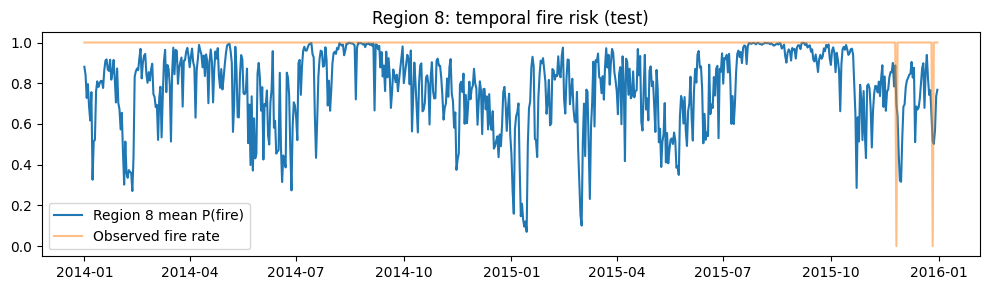

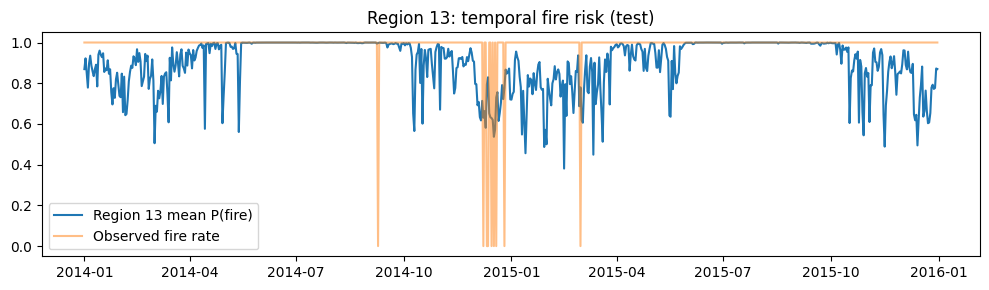

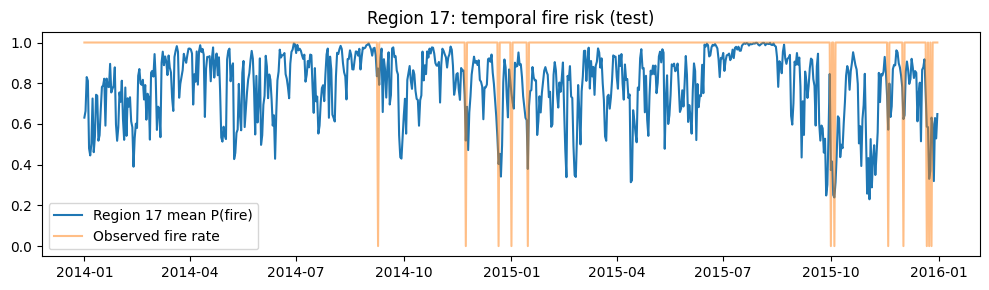

In [17]:
# Pick a few regions with a lot of fires
region_stats = (
    test_with_preds.groupby("region")["fire_occurred"]
    .sum()
    .sort_values(ascending=False)
)
top_regions = region_stats.head(3).index.tolist()
print("Top fire regions:", top_regions)

for r in top_regions:
    subset = test_with_preds[test_with_preds["region"] == r]
    daily_r = (
        subset.groupby("date")
        .agg(mean_pred=("proba", "mean"), fire_rate=("fire_occurred", "mean"))
        .reset_index()
    )

    plt.figure(figsize=(10, 3))
    plt.plot(daily_r["date"], daily_r["mean_pred"], label=f"Region {r} mean P(fire)")
    plt.plot(daily_r["date"], daily_r["fire_rate"], alpha=0.5, label="Observed fire rate")
    plt.title(f"Region {r}: temporal fire risk (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
top_days = (
    daily.sort_values("mean_pred", ascending=False)
    .head(30)
)
top_days[["date", "mean_pred", "fire_rate"]]

,date,mean_pred,fire_rate
580,2015-08-04,0.867820,0.90
109,2014-04-20,0.865530,0.90
579,2015-08-03,0.863429,0.90
578,2015-08-02,0.860480,0.95
110,2014-04-21,0.847289,0.90
101,2014-04-12,0.845154,0.95
487,2015-05-03,0.845036,0.95
184,2014-07-04,0.843220,0.95
100,2014-04-11,0.841705,0.90
99,2014-04-10,0.836957,0.90


In [19]:
# bottom days
bottom_days = (
    daily.sort_values("mean_pred", ascending=True)
    .head(30)
)
bottom_days[["date", "mean_pred", "fire_rate"]]

,date,mean_pred,fire_rate
378,2015-01-14,0.198046,0.45
377,2015-01-13,0.200632,0.40
376,2015-01-12,0.203011,0.40
36,2014-02-06,0.216631,0.40
374,2015-01-10,0.222404,0.65
353,2014-12-20,0.231982,0.40
34,2014-02-04,0.233111,0.35
379,2015-01-15,0.244064,0.45
8,2014-01-09,0.247277,0.50
354,2014-12-21,0.248178,0.40


lstm


In [20]:
# Example features (adjust to what you have)
feature_cols = [
    "avg_temp_c",
    "min_temp_c",
    "max_temp_c",
    "precipitation_mm",
    "avg_wind_speed_kmh",
    "avg_sea_level_pres_hpa",
    "sin_doy",
    "cos_doy",
]

df = data.copy()
df = df.sort_values(["region", "date"])

In [22]:
def build_sequences(df, feature_cols, T=14):
    X_list = []
    y_list = []
    date_list = []
    region_list = []

    for region, group in df.groupby("region"):
        group = group.sort_values("date")
        feats = group[feature_cols].to_numpy(dtype=np.float32)
        labels = group["fire_occurred"].to_numpy(dtype=np.int8)
        dates = group["date"].to_numpy()

        if len(group) < T:
            continue

        for i in range(T - 1, len(group)):
            X_list.append(feats[i - T + 1 : i + 1])  # last T days incl. i
            y_list.append(labels[i])                # fire on day i
            date_list.append(dates[i])
            region_list.append(region)

    X = np.stack(X_list)       # (n_samples, T, n_features)
    y = np.array(y_list)
    date_arr = np.array(date_list)
    region_arr = np.array(region_list)

    return X, y, date_arr, region_arr


T = 14
X, y, dates, regions = build_sequences(df, feature_cols, T=T)

print("X shape:", X.shape)  # e.g., (160000, 14, 8)
print("Positive rate:", y.mean())

X shape: (175060, 14, 8)
Positive rate: 0.73467382611676


In [23]:
train_mask = dates < np.datetime64("2011-01-01")
val_mask = (dates >= np.datetime64("2011-01-01")) & (
    dates < np.datetime64("2014-01-01")
)
test_mask = dates >= np.datetime64("2014-01-01")

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Train size: 138540
Val size: 21920
Test size: 14600


In [24]:
from sklearn.preprocessing import StandardScaler

n_train, T, n_features = X_train.shape

scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, n_features)
scaler.fit(X_train_2d)

def transform_sequences(X, scaler):
    n, T, f = X.shape
    X_2d = X.reshape(-1, f)
    X_2d_scaled = scaler.transform(X_2d)
    return X_2d_scaled.reshape(n, T, f)

X_train = transform_sequences(X_train, scaler)
X_val = transform_sequences(X_val, scaler)
X_test = transform_sequences(X_test, scaler)

In [25]:
from sklearn.utils import class_weight

class_weights_arr = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train,
)
class_weights = {0: class_weights_arr[0], 1: class_weights_arr[1]}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.8395474824729128), 1: np.float64(0.6866301891281076)}


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = keras.Sequential(
    [
        layers.Input(shape=(n_timesteps, n_features)),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="AUC")],
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,793 (22.63 KB)

 Trainable params: 5,793 (22.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.4994 - loss: 0.6931 - val_AUC: 0.5000 - val_loss: 0.6940
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.4995 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6926
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.5022 - loss: 0.6931 - val_AUC: 0.5000 - val_loss: 0.6980
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.4990 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6931
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.5002 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6919
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.4986 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6935
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.5000 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6938
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.5002 - loss: 0.6932 - val_AUC: 0.5000 - val_loss: 0.6918
Epoch 9/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/st

In [28]:
from sklearn.metrics import roc_auc_score, average_precision_score

probs_test_lstm = model.predict(X_test).ravel()

print("LSTM Test ROC-AUC:", roc_auc_score(y_test, probs_test_lstm))
print("LSTM Test PR-AUC:", average_precision_score(y_test, probs_test_lstm))

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Test ROC-AUC: 0.5
LSTM Test PR-AUC: 0.7342465753424657
